In [1]:
# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
# https://gist.github.com/minrk/3301035
%load_ext watermark
%load_ext autoreload
%autoreload 
from typing import List
%watermark -a 'Jae H. Choi' -d -t -v -p typing

Jae H. Choi 2020-10-28 00:24:17 

CPython 3.8.3
IPython 7.16.1

typing unknown


# Linear Regression-ii Case Study, Unit 8 - The Boston Housing Dataset

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=.5)


***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
*Image from http://www.learner.org/courses/againstallodds/about/glossary.html. Note this image uses $\alpha$ and $\beta$ instead of $\beta_0$ and $\beta_1$.*

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i^2 = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N (y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i) \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - N \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i = 0 \\
& N \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{N} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{N} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{N} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i (y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N x_i (y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N (x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x}\sum_{i=1}^N x_i - \hat{\beta}_1 \sum_{i=1}^N x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [2]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
boston.data.shape

(506, 13)

In [5]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [6]:
# Print description of Boston housing data set
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Now let's explore the data set itself. 

In [7]:
bos = pd.DataFrame(boston.data)
# ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
# 'B' 'LSTAT']
bos.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


There are no column names in the DataFrame. Let's add those. 

In [8]:
bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [9]:
print(boston.target.shape)

(506,)


In [10]:
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [11]:
bos.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

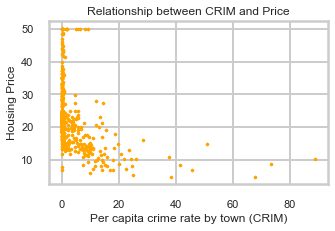

In [12]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.scatter(bos.CRIM, bos.PRICE, marker='x', color='orange', s=3) # size=3
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")
plt.show()

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set I</h3>

<p><b>Exercise1:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>


<p><b>Exercise2:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>

<p><b>Exercise3:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

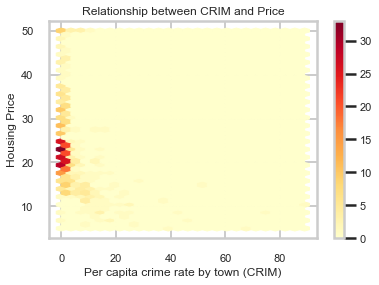

In [13]:
# Part 2-1 Excercise1
# hexbin Plot density against alcohol
fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.hexbin(x='CRIM',y='PRICE', data=bos, gridsize=(25,25), cmap="YlOrRd")
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")
plt.colorbar()
plt.show()

**Excercise1**: <font color='red'> Non-linear; the data is heavily skewed to the right. However, there are some cases that data is either only horizontally or vertically distributed. That means prices on those data are not affected by crime rate. Under 25 of the housing price (i.e. $\text{PRICE} \geq 25$), crime rate does not affect housing price at all. Housing price could be non-linearly related to crime under the 25 threshold. <br>
The outliers are located above 60 of crime rate on the distribution of housing prices. Since linear regression is sensitive to outliers, it is not recommended for identifying the relation between CRIM and PRICE
</font>

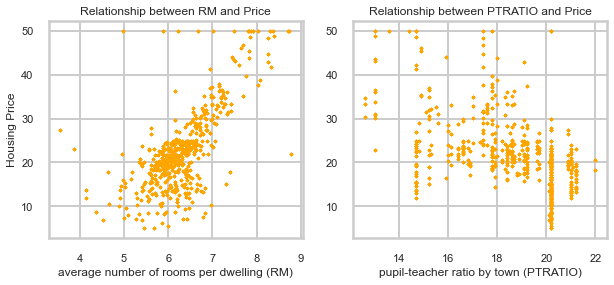

In [14]:
# Part 2-1 Excercise2
# hexbin Plot density against alcohol
fig, axes = plt.subplots(1,2, figsize=(10, 4))
axes[0].scatter(x='RM',y='PRICE', data=bos, marker='x', color='orange', s=4)
axes[0].set_xlabel("average number of rooms per dwelling (RM)")
axes[0].set_ylabel("Housing Price")
axes[0].set_title("Relationship between RM and Price")

axes[1].scatter(x='PTRATIO',y='PRICE', data=bos, marker='x', color='orange', s=4)
axes[1].set_xlabel("pupil-teacher ratio by town (PTRATIO)")

axes[1].set_title("Relationship between PTRATIO and Price")
plt.show()

**Excercise2**: <font color='red'>  RM and PRICE has a trend of linear relationship within the range of 4.5 RM to 8. There are some cases that housing prices are steady as 50. Those data can be considered outliers. However, generally from 5 rooms upto 8 rooms, numbers of room and housing price are positively correlated. <br> <br>
The PTRATIO and PRICE's relationship has vertical distribution because PTRATIO is discrete. Linear regression is not recommended to discrete variables. Moreover, within the range between 14 of and 20 of PTRATIO, housing distribution is not much changed. Howevver, below 14 on x-axis, PRICE's range is shifted upward (started from 23ish) while above 20 on x-axis, PRICE's range is shifted downward (started from 4). Thus, PTRATIO afftects PRICE in those ranges. 
> Note that RM is average number of rooms and PTRATIO is pupil-teacher ratio.
</font>

In [15]:
bos.info() # seems like all other values are continuous except PTRATIO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


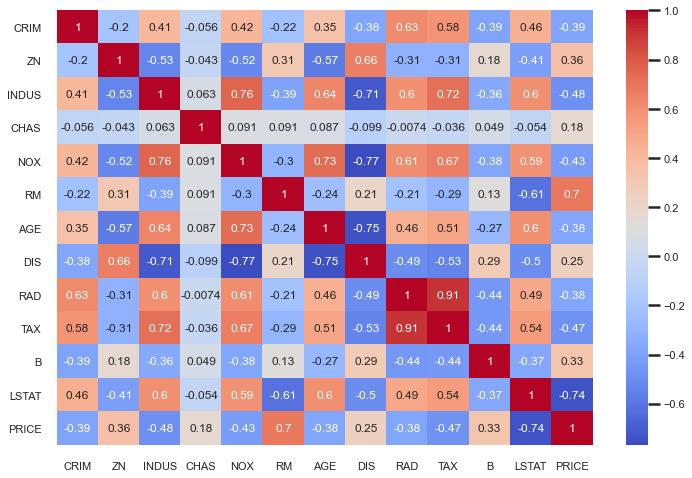

In [16]:
# Part 2-1 Excercise3
# Check relationship via a heatmap of the data 
fig, ax = plt.subplots(1,1, figsize=(12, 8))
bos_no_ptratio=bos.loc[:, bos.columns != 'PTRATIO']
sns.heatmap(bos_no_ptratio.corr(), annot=True, cmap="coolwarm") 
# the warmer, the more correlated; the colder, the less correlated.
plt.show()

**Excercise3**: <font color='red'> PRICE is affected by following features; above absolute value of $|0.40|$: <br>
- INDUS (proportion of non-retail business acres per town): -0.48
- RM (average number of rooms per dwelling): 0.7
- TAX (full-value property-tax rate per $10,000): -0.47
- LSTAT (\% lower status of the population): -0.74
- NOX (nitric oxides concentration (parts per 10 million)): -0.43
</font>

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

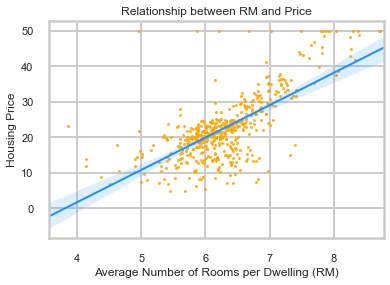

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True, 
            scatter_kws={'marker':'x','color':'orange', 's':4},
            line_kws={'linewidth':2,'color':'dodgerblue'})
plt.xlabel("Average Number of Rooms per Dwelling (RM)")
plt.ylabel("Housing Price")
plt.title("Relationship between RM and Price")
plt.show()

### Histograms
***


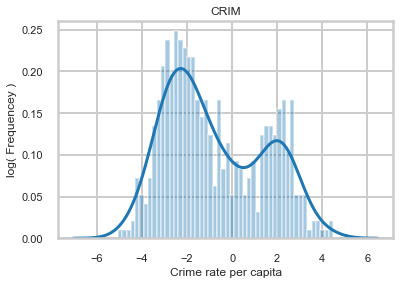

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
sns.distplot(np.log(bos.CRIM), hist=True, kde=True, bins=50)
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("log( Frequencey )")
plt.show()

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise1:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

<p><b>Exercise2:</b> Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.</p>
</div>

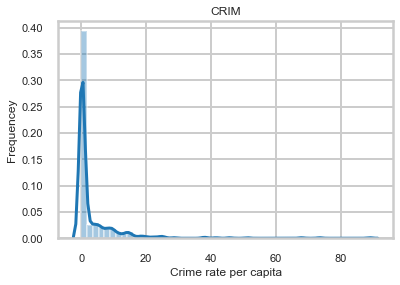

In [19]:
# Part 2-2 Excercise1
fig, ax = plt.subplots(1,1, figsize=(6, 4))
sns.distplot(bos.CRIM, hist=True, kde=True, bins=50)
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequencey")
plt.show()

**Excercise1**: <font color='red'> **Purpose of Log Transformation:** 
Logarithm transformations help making highly skewed distributions less skewed via using the nature of logarithms (Remember that logarithm functions are inverse function of exponention). That's why log transformations can effectively scale down those extreme datapoints more than others, making patterns in the data more interpretable. [Reference](http://onlinestatbook.com/2/transformations/log.html)

> **NOTE**: The comparison of the means of log-transformed data is actually a comparison of geometric means. 
</font>

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'marker'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


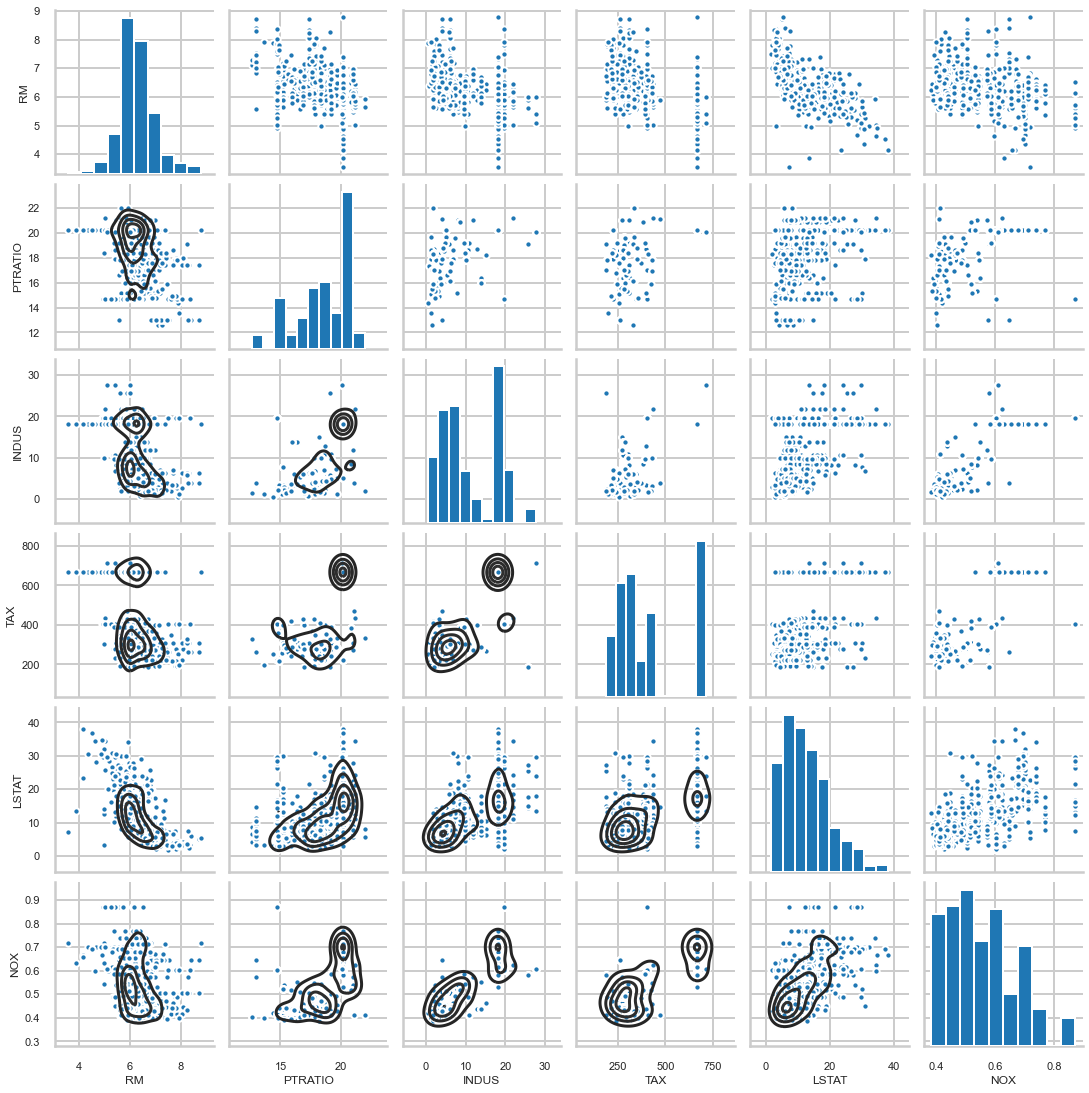

In [114]:
# Part 2-2 Excercise2
features=['RM', 'PTRATIO','INDUS', 'TAX', 'LSTAT', 'NOX']
effective_bos = bos[features]

pp=sns.pairplot(effective_bos, 
             markers='o',
             plot_kws={'s':40, 'linewidth':2})

pp.map_lower(sns.kdeplot, levels=4, color=".2")

plt.show()

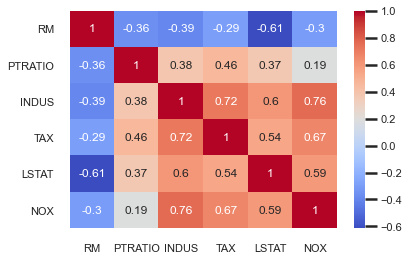

In [115]:
# Check relationship via a heatmap of the data 
fig, ax = plt.subplots(1,1, figsize=(6, 4))
sns.heatmap(effective_bos.corr(), annot=True, cmap="coolwarm") 
# the warmer, the more correlated; the colder, the less correlated.
plt.show()

**Excercise2**: <font color='red'> From the previous heatmap, we saw the above list has meaningful impact on housing prices. In this exercise, we would like to see if those chosen features are independent or not. Here, number of rooms RM has a negative correlation with percent of lower status of population LSTAT. Thus, we can consider either including LSTAT or excluding LSTAT to see if that affects R-squared value. 
> INDUS (proportion of non-retail business acres per town) <br>
> RM (average number of rooms per dwelling) <br>
> TAX (full-value property-tax rate per $10,000) <br>
> LSTAT (% lower status of the population) <br>
</font>

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [116]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [117]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           2.49e-74
Time:                        15:28:41   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

In [118]:
bos.RM.shape, bos.PRICE.shape

((506,), (506,))

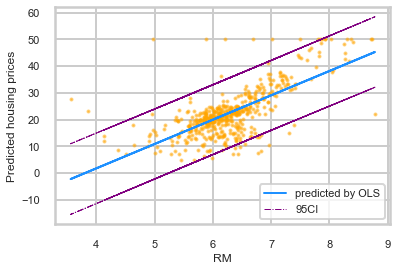

In [119]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(m)

# plot prediction of boston housing price based on number of rooms
x_pred = bos.RM
x_pred = sm.add_constant(x_pred)
y_pred = m.predict(x_pred)
y_test = bos.PRICE
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.scatter(x_pred['RM'], y_test, alpha=0.5, color='orange', s=4)
ax.plot(x_pred['RM'], y_pred, '-', color='dodgerblue', linewidth=2, label='predicted by OLS')
ax.plot(x_pred['RM'], confidence_interval_lower, color='purple', linewidth=1, linestyle='-.', label='95CI')
ax.plot(x_pred['RM'], confidence_interval_upper, color='purple', linewidth=1, linestyle='-.')

plt.xlabel('RM')
plt.ylabel('Predicted housing prices')
plt.legend()
plt.show()

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

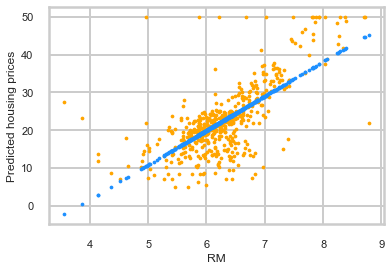

,PRICE,0
0,24.0,25.175746
1,21.6,23.774021
2,34.7,30.728032
3,33.4,29.025938
4,36.2,30.382152
...,...,...
501,22.4,25.339584
502,20.6,21.034286
503,23.9,28.825691
504,22.0,27.169108


In [120]:
# Part 3-1 Excercise
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.scatter(x_pred['RM'], y_test, s=3, color='orange')
plt.scatter(x_pred['RM'], m.fittedvalues, s=3, color='dodgerblue')
plt.xlabel('RM')
plt.ylabel('Predicted housing prices')
#plt.legend()
plt.show()
# This shows the comparison of true vs. pred
pd.concat([bos.PRICE, m.fittedvalues], axis=1)


**Excercise**: <font color='red'> The fittedvalues are expected as linear, lying on the predicted line.</font>

### Fitting Linear Regression using `sklearn`


In [121]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
sk_lm = sklearn.linear_model.LinearRegression()
sk_lm

LinearRegression()

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [122]:
# Look inside lm object
# lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [123]:
X_ols = sm.add_constant(X)
rModel_OLS2 = sm.OLS(bos.PRICE, X_ols)
reg_ols2 = rModel_OLS2.fit()
reg_ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          6.72e-135
Time:                        15:28:44   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.000      26.432      46.487
CRIM          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
ZN             0.0464      0.014      3.382      0.001       0.019       0.073
INDUS          0.0206      0.061      0.334      0.738      -0.100       0.141
CHAS           2.6867      0.862      3.118      0.002       0.994       4.380
NOX          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
RM             3.8099      0.418      9.116      0.000       2.989       4.631
AGE            0.0007      0.013      0.052      0.958      -0.025       0.027
DIS           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
RAD            0.3060      0.066      4.613      0.000       0.176       0.436
TAX           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
PTRATIO       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
B              0.0093      0.003      3.467      0.001       0.004       0.015
LSTAT         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [124]:
# Use all 13 predictors to fit linear regression model
# Compare the values from sk-learn with with those from OLS
sk_lm.fit(X, bos.PRICE) # cheated => should've fitted X_train and y_train
sk_lm.intercept_, sk_lm.coef_

(36.45948838509015,
 array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
        -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
         3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
        -5.24758378e-01]))

In [125]:
from sklearn.model_selection import train_test_split #  tran test data split

X_train, X_test, y_train, y_test = train_test_split(X, bos.PRICE, test_size=0.25, random_state=42)

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise1:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).</p>

<p><b>Exercise2:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

<p><b>Exercise3:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>


In [126]:
sk_lm_no_const = sklearn.linear_model.LinearRegression(fit_intercept=False)
sk_lm_no_const.fit(X,bos.PRICE)
sk_lm_no_const.intercept_, sk_lm_no_const.coef_

(0.0,
 array([-9.28965170e-02,  4.87149552e-02, -4.05997958e-03,  2.85399882e+00,
        -2.86843637e+00,  5.92814778e+00, -7.26933458e-03, -9.68514157e-01,
         1.71151128e-01, -9.39621540e-03, -3.92190926e-01,  1.49056102e-02,
        -4.16304471e-01]))

R^2 score for Yes intercept: 0.74                    R^2 score for No intercept: 0.73


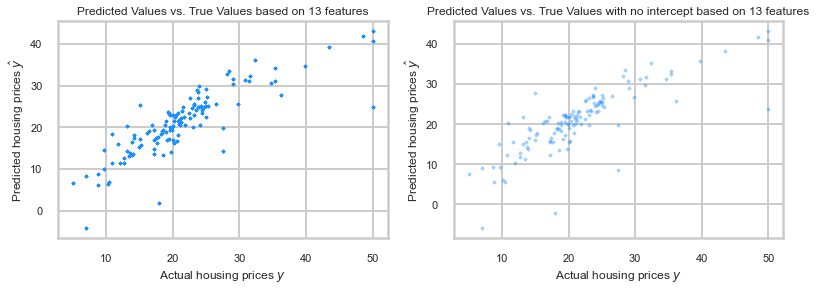

In [127]:
# Part 3-2 Excercise1

print(f"R^2 score for Yes intercept: {sk_lm.score(X_train, y_train):0.2f}" , end=' '*20)
print(f"R^2 score for No intercept: {sk_lm_no_const.score(X_train, y_train):0.2f}")
y_pred = sk_lm.predict(X_test)
y_pred_no_const = sk_lm_no_const.predict(X_test)

fig, axes = plt.subplots(1,2, figsize=(13,4))
axes[0].scatter(y_test, y_pred, marker='x', color='dodgerblue', s=4)
axes[0].set_xlabel('Actual housing prices $y$')
axes[0].set_ylabel('Predicted housing prices $\\hat{y}$')
axes[0].set_title('Predicted Values vs. True Values based on 13 features')

axes[1].scatter(y_test, y_pred_no_const, marker='x', alpha=0.4, color='dodgerblue', s=4)
axes[1].set_xlabel('Actual housing prices $y$')
axes[1].set_ylabel('Predicted housing prices $\\hat{y}$')
axes[1].set_title('Predicted Values vs. True Values with no intercept based on 13 features')

plt.show()

**Excercise1**: <font color='red'> 
Removing the intercept would introduce bias to the other regression parameters. In this case, those two plots shown above tell that left graph is more sparse than the right one. $R^2$ is slightly better for the one with intercept. This makes sense cause there is no housing price start from \$ 0. Thus, it would be a better estimate with an intercept.   </font>

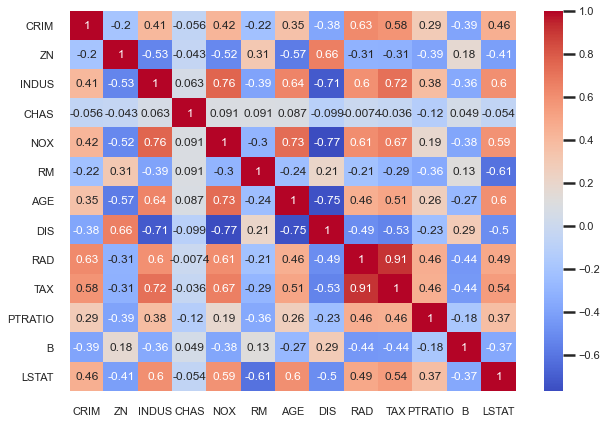

In [128]:
# Part 3-2 Excercise2
fig, ax = plt.subplots(1,1, figsize=(10, 7))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm") 

# the warmer, the more correlated; the colder, the less correlated.
plt.show()

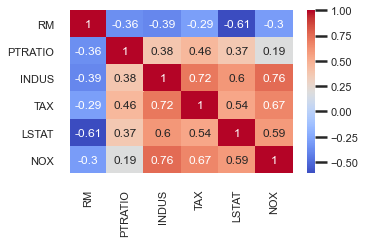

In [129]:
fig, ax = plt.subplots(1,1, figsize=(5, 3))
ax=sns.heatmap(effective_bos.corr(), annot=True, cmap="coolwarm") 

# the warmer, the more correlated; the colder, the less correlated.
plt.show()

In [130]:
#effective_bos.shape, X.shape
X[effective_bos.columns].shape, y_pred_eff.shape

((506, 6), (506,))

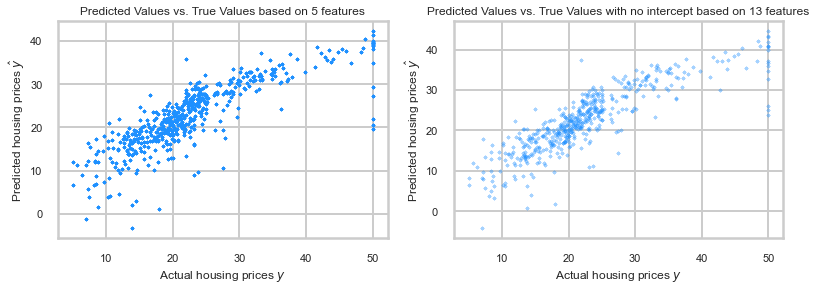


R^2 score based on 6 features: 0.68
R^2 score based on 11 features: 0.74


In [139]:
sk_lm.fit(effective_bos,bos.PRICE)
y_pred_eff = sk_lm.predict(X[effective_bos.columns])
r2_score_6feat = sk_lm.score(X[effective_bos.columns], bos.PRICE)

fig, axes = plt.subplots(1,2, figsize=(13,4))
axes[0].scatter(bos.PRICE, y_pred_eff, marker='x', color='dodgerblue', s=4)
axes[0].set_xlabel('Actual housing prices $y$')
axes[0].set_ylabel('Predicted housing prices $\\hat{y}$')
axes[0].set_title('Predicted Values vs. True Values based on 5 features')

sk_lm.fit(X,bos.PRICE)
y_pred_all = sk_lm.predict(X)
r2_score_13feat = sk_lm.score(X, bos.PRICE)

axes[1].scatter(bos.PRICE, y_pred_all, marker='x', alpha=0.4, color='dodgerblue', s=4)
axes[1].set_xlabel('Actual housing prices $y$')
axes[1].set_ylabel('Predicted housing prices $\\hat{y}$')
axes[1].set_title('Predicted Values vs. True Values with no intercept based on 13 features')

plt.show()
print()
print(f"R^2 score based on 6 features: {r2_score_6feat:0.2f}")
print(f"R^2 score based on 11 features: {r2_score_13feat:0.2f}")


**Excercise2**: <font color='red'> 
Not really. As you can see the heatmap, RM is independently and identically distributed (iid). However, NOX is highly correlated with INDUX, TAX, and LSTAT. Similarly, LSTAT is highly correlated with RM, INDUS, TAX, and NOX. Normality does not assume independence between residuals, and residuals could be normally distributed but some are dependent on each other. 

[This Stack Exchange post](https://stats.stackexchange.com/questions/248615/what-is-the-difference-between-normal-and-iid) for iid
1. They are independent
2. They have constant variance (homoscedasticity)

> Refereces: <br>
> [Normality and IID](https://stats.stackexchange.com/questions/248615/what-is-the-difference-between-normal-and-iid) <br>
> [Assumptions of Linear Regression](https://towardsdatascience.com/assumptions-of-linear-regression-algorithm-ed9ea32224e1) <br>
> [Assumptions 2 - in R](http://r-statistics.co/Assumptions-of-Linear-Regression.html)</font>

**Excercise3**: <font color='red'> 
No; normality is not required for linear regression. It is more accurate if the errors of a linear regression model are distributed normally or the dependent variable $Y$ has a conditional normal distribution (rather than if the dependent variable complies fully with a normal distribution) when evaluating whether the “normality assumption” is fulfilled for linear regression. However, the estimated parameters and estimates within thier confidence interval remain robust due to the central limit theorem if sample is large enough.
    
<img src="./images/CL_linear_reg.png" alt="Drawing" style="width: 200px;"/>

> [Reference](https://iovs.arvojournals.org/article.aspx?articleid=2128171)
</font>

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [140]:
print('Estimated intercept coefficient: {}'.format(sk_lm.intercept_))

Estimated intercept coefficient: 36.45948838509015


In [141]:
print('Number of coefficients: {}'.format(len(sk_lm.coef_)))

Number of coefficients: 13


In [142]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': sk_lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [143]:
# first five predicted prices
sk_lm.predict(X)[0:5]

array([30.00384338, 25.02556238, 30.56759672, 28.60703649, 27.94352423])

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set III</h3>

<p><b>Exercise1:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

<p><b>Exercise2:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

<p><b>Exercise3:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>
</div>

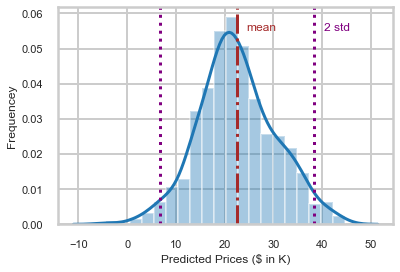

In [154]:
# Part 3-3 Excercise1

fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.distplot(sk_lm.predict(X), hist=True, kde=True, bins='auto')
plt.axvline(np.mean(sk_lm.predict(X)), color='brown', linestyle='-.')
plt.axvline(np.mean(sk_lm.predict(X))+2*np.std(sk_lm.predict(X)), color='purple', linestyle=':')
plt.axvline(np.mean(sk_lm.predict(X))-2*np.std(sk_lm.predict(X)), color='purple', linestyle=':')
ax.text(x=np.mean(sk_lm.predict(X))+2,y=0.055, s='mean', alpha=1.0, color='brown')
ax.text(x=np.mean(sk_lm.predict(X))+2*np.std(sk_lm.predict(X))+2,y=0.055, s='2 std', alpha=1.0, color='purple')

# plt.hist(sk_lm.predict(X), bins='auto', )
plt.xlabel("Predicted Prices ($ in K)")
plt.ylabel("Frequencey")
plt.show()

**Excercise1**: <font color='red'> 
As expected, the plot follows central limit theorem. The shape looks a bell curve. The area under the curve within $\pm$ 2std seems 95% of the entire region. </font>

0.7406426641094095


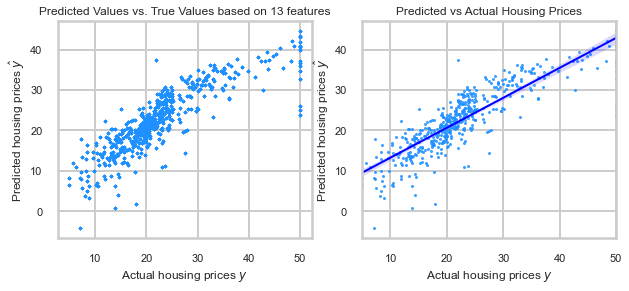

In [196]:
# Part 3-3 Excercise2
print(sk_lm.score(X, bos.PRICE))
fig, axes = plt.subplots(1,2, figsize=(10,4))

axes[0].scatter(bos.PRICE, sk_lm.predict(X), marker='x', color='dodgerblue', s=4)
axes[0].set_xlabel('Actual housing prices $y$')
axes[0].set_ylabel('Predicted housing prices $\\hat{y}$')
axes[0].set_title('Predicted Values vs. True Values based on 13 features')

axes[1]=sns.regplot(x=bos.PRICE, y=sk_lm.predict(X), fit_reg = True, 
            scatter_kws={'marker':'x','color':'dodgerblue', 's':4},
            line_kws={'linewidth':2,'color':'blue'})
axes[1].set_xlabel('Actual housing prices $y$')
axes[1].set_ylabel('Predicted housing prices $\\hat{y}$')
axes[1].set_title("Predicted vs Actual Housing Prices")

plt.show()

**Excercise2**: <font color='red'> 
Comparison between predicted PRICE and the gold standard PRICE seems pretty linear; $R^2$ is 0.74 which is not bad for linear regression.  </font>

**Excercise3**: <font color='red'> <br>
`statsmodels`: It is more powerful when it comes to statistical analysis with model.summary() function. We can check how much good fit a given model is to the data. <br>
`sk-learn`: It is based on machine learning tradition for finding the best predictive model. It can suffle and split the data to apply cross-validation or to allow us for hyper-parameter tuning from variance-bias tradeoff. Linear regression model can be compared with other models in the `sk-learn` package.</font>

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [202]:
print(f"RSS: {np.sum((bos.PRICE - sk_lm.predict(X)) ** 2): .1f}")

RSS: 11078.8


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [204]:
print(f"ESS: {np.sum((sk_lm.predict(X) - np.mean(bos.PRICE)) ** 2): .1f}")

ESS:  31637.5


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{RSS}{N-K-1}$$

$$MSR = \frac{ESS}{K}$$

**Remember:** Notation may vary across resources particularly the use of $R$ and $E$ in $RSS/ESS$ and $MSR/MSE$. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set IV</h3>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise1:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise2:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise3:</b> Compute the $F$-statistic. What does it tell you?</p>

<p><b>Exercise4:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>

In [221]:
# Part 3-4 Excercise1
#sk_lm = sklearn.linear_model.LinearRegression()
sk_lm.fit(bos.PTRATIO.values.reshape(-1,1), bos.PRICE)

print(f"Coefficient: {sk_lm.coef_}")
print(f"Intercept: {sk_lm.intercept_: .2f}")

Coefficient: [-2.1571753]
Intercept:  62.34


**Excercise1**: <font color='red'> 
PTRATIO is negatively correlated with PRICE. The less pupil and teacher ratio is, the more expensive housing prices are.   </font>

In [224]:
# Part 3-4 Excercise2
r_sq = sk_lm.score(X[['PTRATIO']], bos.PRICE)
print(f"R^2 = {r_sq:.2f}")

R^2 = 0.26


**Excercise2**: <font color='red'> 
However, $R^2$ is very small, so PRICE is linearly less affected by PTRATIO. </font>

In [225]:
# Part 3-4 Excercise3
N = bos.PTRATIO.count()
K = 1
def F_stat(N, K, r_sq):
    return (r_sq / (1 - r_sq)) * ((N - K - 1) / K)

F = F_stat(N,K,r_sq)
print(f"F-statistic = {F:.2f}", )

F-statistic = 175.11


**Excercise3**: <font color='red'> 
The F-statistic is very high which means the regression coefficients are statistically significant.
  </font>

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise1:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>

<p><b>Exercise2:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise3:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>

In [236]:
# Part 3-5 Excercise1
sk_lm.fit(X[['CRIM', 'RM', 'PTRATIO']], bos.PRICE)
print(f"Coefficient: {sk_lm.coef_}")
print(f"Intercept: {sk_lm.intercept_: .2f}")
print()

r_sq = sk_lm.score(X[['CRIM', 'RM', 'PTRATIO']], bos.PRICE)
N = bos.PRICE.count()
K = 3
F = F_stat(N,K,r_sq)
print(f"F-statistic = {F:.2f}", )

Coefficient: [-0.20496083  7.3804111  -1.0695461 ]
Intercept: -3.37

F-statistic = 245.16


**Excercise1**: <font color='red'> 
The F-statistic is very high which means the regression coefficients are statistically significant.   </font>

In [237]:
# Part 3-5 Excercise2
print(f"R^2 = {r_sq:.2f}")

R^2 = 0.59


**Excercise2**: <font color='red'> 
The $R^2$ value is 0.59. That tells the model with 3 features of CRIM, RM, and PTRATIO is a better PRICE predictor than the one with 1 feature of PTRATIO. </font>

**Excercise3**: <font color='red'> From the previous heatmap, the meaningful features on housing prices are following:
- INDUS (proportion of non-retail business acres per town) <br>
- RM (average number of rooms per dwelling) <br>
- TAX (full-value property-tax rate per $10,000) <br>
- LSTAT (% lower status of the population) <br>
</font>

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{reduced} - RSS_{full}}{DF_{reduced} - DF_{full}} \right)}{\left( \frac{RSS_{full}}{DF_{full}} \right)}$$

where $DF_x = N - K_x - 1$ where $K_x$ is the number of variables in model $x$.

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="span5 alert alert-info">
<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>

In [246]:
# Part 4 Excercise
RSS_reduced = np.sum((bos.PRICE - sk_lm.predict(X[['CRIM', 'RM', 'PTRATIO']])) ** 2)

sk_lm2 = LinearRegression()
sk_lm2.fit(X[['CRIM', "RM", "PTRATIO", "LSTAT", "NOX"]], bos.PRICE)

RSS_full = np.sum((bos.PRICE - sk_lm2.predict(X[['CRIM', 'RM', 'PTRATIO', "LSTAT", "NOX"]])) ** 2)

DF_reduced = bos.PRICE.count() - 3 - 1
DF_full = bos.PRICE.count() - 5 - 1

F = ((RSS_reduced - RSS_full)/(DF_reduced - DF_full)) / (RSS_full/DF_full)

print(f"F = {F:.2f}")
print()

m1 = sm.OLS(bos.PRICE, X[['CRIM', 'RM', 'PTRATIO']], hasconst=True).fit()
m2 = sm.OLS(bos.PRICE, X[['CRIM', 'RM', 'PTRATIO', "LSTAT", "NOX"]], hasconst=True).fit()
print(f"AIC with 'CRIM', 'RM', 'PTRATIO'                 = {m1.aic:.2f}", )
print(f"AIC with 'CRIM', 'RM', 'PTRATIO', 'LSTAT', 'NOX' = {m2.aic:.2f}")

F = 68.58

AIC with 'CRIM', 'RM', 'PTRATIO'                 = 3230.65
AIC with 'CRIM', 'RM', 'PTRATIO', 'LSTAT', 'NOX' = 3129.20



## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="span5 alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise1:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise2:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise3:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise4:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise5:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise6:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>

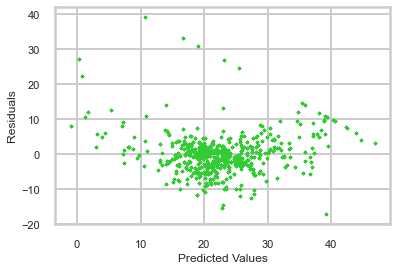

In [248]:
# Part 5 Excercise1
# Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?
predicted_values = sk_lm.predict(X[['CRIM', 'RM', 'PTRATIO']])

residuals = bos.PRICE - predicted_values

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.scatter(predicted_values, residuals, marker='x', color='limegreen', s=4)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

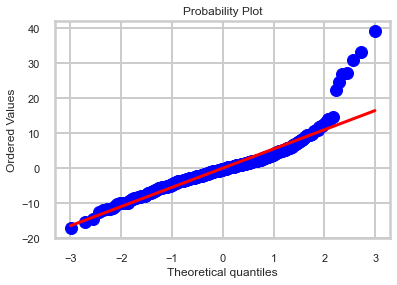

In [249]:
# Part 5 Excercise2
# Construct a quantile plot of the residuals. What does the plot tell you?
import pylab

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()


The qq plot shows that there is a positive skew with the data.



**Excercise3**: <font color='red'> The fitted values versus residuals plot shows the relationship between the predicted values and residuals. It could tell you whether a linear model is appropriate. It also shows outliers. The quantile plot tells you how the data is distributed. It does not really identify outliers but it is easier to eyeball.
    </font>

**Excercise4**: <font color='red'> There are outliers in the model which are most likely due to differences in prices depending on location.
</font>

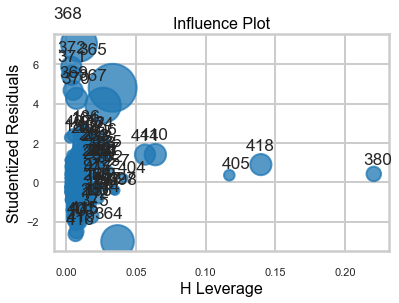

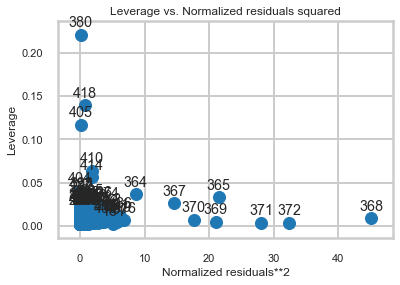

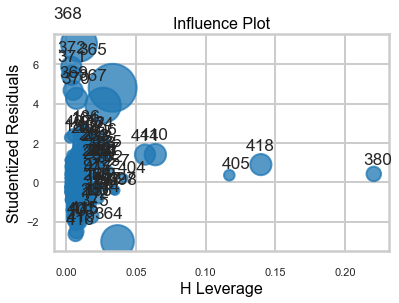

In [250]:
# Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.

from statsmodels.graphics.regressionplots import *

fitted = ols('PRICE ~ CRIM + RM + PTRATIO',bos).fit()

plot_leverage_resid2(fitted)
influence_plot(fitted)

In [251]:
# Remove the outliers and high leverage points from your model and run the regression again. How do the results change?

def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

no_outliers_CRIM = reject_outliers(X['CRIM'].values)
no_outliers_RM = reject_outliers(X['RM'].values)
no_outliers_PTRATIO = reject_outliers(X['PTRATIO'].values)

df = bos[(bos['CRIM'].isin(no_outliers_CRIM)) & (bos['RM'].isin(no_outliers_RM)) & (bos['PTRATIO'].isin(no_outliers_PTRATIO))]

lr4 = LinearRegression()
lr4.fit(df[['CRIM', "RM", "PTRATIO"]], df.PRICE)

r_2 = lr4.score(X[['CRIM', "RM", "PTRATIO"]], bos.PRICE)
print("R^2 =", r_2)

R^2 = 0.5220723007890391


# Your turn.
